In [ ]:
!pip install econml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from econml.dml import CausalForestDML
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

In [ ]:
from datetime import datetime
import time
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OnlineNewsPopularity_interacted.csv')

In [ ]:
df = df.drop(['url'],axis=1)
X = [' n_tokens_title', ' n_tokens_content',
       ' num_imgs', ' num_videos',
       ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend',  ' global_subjectivity',
       ' global_sentiment_polarity', ' global_rate_positive_words',
       ' global_rate_negative_words', ' rate_positive_words',
       ' rate_negative_words', ' avg_positive_polarity',
     ' min_positive_polarity', ' max_positive_polarity',
       ' avg_negative_polarity', ' min_negative_polarity',
       ' max_negative_polarity', ' title_subjectivity',
       ' title_sentiment_polarity', ' abs_title_subjectivity',
       ' abs_title_sentiment_polarity',
       ' data_channel_is_Entertainment',
       ' week_end_cross_data_channel_is_Work',
       ' week_end_cross_data_channel_is_Entertainment',
       ' week_day_cross_data_channel_is_Work',
       ' week_day_cross_data_channel_is_Entertainment',
       ' shares'
       ]
df = df[X]

In [ ]:
treatments = [' n_tokens_title', ' n_tokens_content',
       ' num_imgs', ' num_videos',
       ' num_keywords', ' global_rate_positive_words',
       ' global_subjectivity',' global_rate_negative_words',
       ' rate_negative_words',' avg_negative_polarity', ' min_negative_polarity',
       ' max_negative_polarity',
       ]
binary_treatments =  [' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend',
       ' week_end_cross_data_channel_is_Work',
       ' week_end_cross_data_channel_is_Entertainment',
       ' week_day_cross_data_channel_is_Work',
       ' week_day_cross_data_channel_is_Entertainment'
       ]




In [ ]:
def run_Casual_Forest(df,treatment):
    outcome = ' shares'
    all_variables = [' n_tokens_title', ' n_tokens_content',
       ' num_imgs', ' num_videos',
       ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend',  ' global_subjectivity',
       ' global_sentiment_polarity', ' global_rate_positive_words',
       ' global_rate_negative_words', ' rate_positive_words',
       ' rate_negative_words', ' avg_positive_polarity',
       ' min_positive_polarity', ' max_positive_polarity',
       ' avg_negative_polarity', ' min_negative_polarity',
       ' max_negative_polarity', ' title_subjectivity',
       ' title_sentiment_polarity', ' abs_title_subjectivity',
       ' abs_title_sentiment_polarity',
       ' data_channel_is_Entertainment',
       ' week_end_cross_data_channel_is_Work',
       ' week_end_cross_data_channel_is_Entertainment',
       ' week_day_cross_data_channel_is_Work',
       ' week_day_cross_data_channel_is_Entertainment',
       ' shares'
       ]
    covariates = [ele for ele in all_variables if ele != treatment and ele != outcome]


    df = df.dropna(axis=0, subset=all_variables)

    from sklearn.model_selection import train_test_split
    train, test = train_test_split(df, test_size=0.2)

    Y = train[outcome]
    T = train[treatment]
    X = train[covariates]
    W = None
    X_test = test[covariates]

    from sklearn import preprocessing
    scaler = preprocessing.StandardScaler().fit(X)

    X_scaled = scaler.transform(X)
    # set parameters for causal forest
    causal_forest = CausalForestDML(criterion='het',
                                    n_estimators=10000,
                                    max_depth=10,
                                    max_samples=0.5,
                                    discrete_treatment=False,
                                    honest=True,
                                    inference=True,
                                    cv=4,
                                    model_t=DecisionTreeRegressor(),
                                    model_y=DecisionTreeRegressor(),
                                    )
    # fit train data to causal forest model
    causal_forest.fit(Y, T, X=X_scaled, W=W)
    print("treatment:",treatment)
    # estimate the CATE with the test set
    print("average constant marginal CATE :",causal_forest.const_marginal_ate(X_test))
    # print("Inference:",causal_forest.const_marginal_ate_inference(X_test))

    # use causal forest model to estimate treatment effects
    treatment_effects = causal_forest.effect(X)
    # calculate lower bound and upper bound confidence intervals
    lb, ub = causal_forest.effect_interval(X, alpha=0.05)

    # convert arrays to pandas dataframes for plotting
    te_df = pd.DataFrame(treatment_effects, columns=['cate'])
    lb_df = pd.DataFrame(lb, columns=['lb'])
    ub_df = pd.DataFrame(ub, columns=['ub'])
    te_df.fillna(0)
    lb_df.fillna(0)
    ub_df.fillna(0)

    # merge dataframes and sort
    #df = te_df.merge(lb_df, left_on=te_df.index, right_on=lb_df.index, how='left')
    df = te_df.merge(lb_df, left_index=True, right_index=True)
    #print(df)
    df = df.merge(ub_df, left_index=True, right_index=True )

    df.sort_values('cate', inplace=True, ascending=True)
    df.reset_index(inplace=True, drop=True)

    # calculate rolling mean
    z = df.rolling(window=30, center=True).mean()




    # set plot size
    fig, ax = plt.subplots(figsize=(12, 8))
    # plot lines for treatment effects and confidence intervals
    ax.plot(z['cate'],
            marker='.', linestyle='-', linewidth=0.5, label='heterogeneous treatment effect', color='indigo')
    # ax.plot(z['lb'],
    #         marker='.', linestyle='-', linewidth=0.5, color='steelblue')
    # ax.plot(z['ub'],
    #         marker='.', linestyle='-', linewidth=0.5, color='steelblue')


    # label axes and create legend
    ax.set_ylabel('Treatment Effects')
    ax.set_xlabel('Data points sorted by treatment effert, from little to large')
    ax.legend()
    plt.show()

In [ ]:
for treatment in treatments:
    print(treatment)

 n_tokens_title
 n_tokens_content
 num_imgs
 num_videos
 num_keywords
 global_rate_positive_words
 global_subjectivity
 global_rate_negative_words
 rate_negative_words
 avg_negative_polarity
 min_negative_polarity
 max_negative_polarity


time 2023-05-30 09:53:47.130729 treatment  n_tokens_title
treatment:  n_tokens_title
average constant marginal CATE : -188.46906241143677


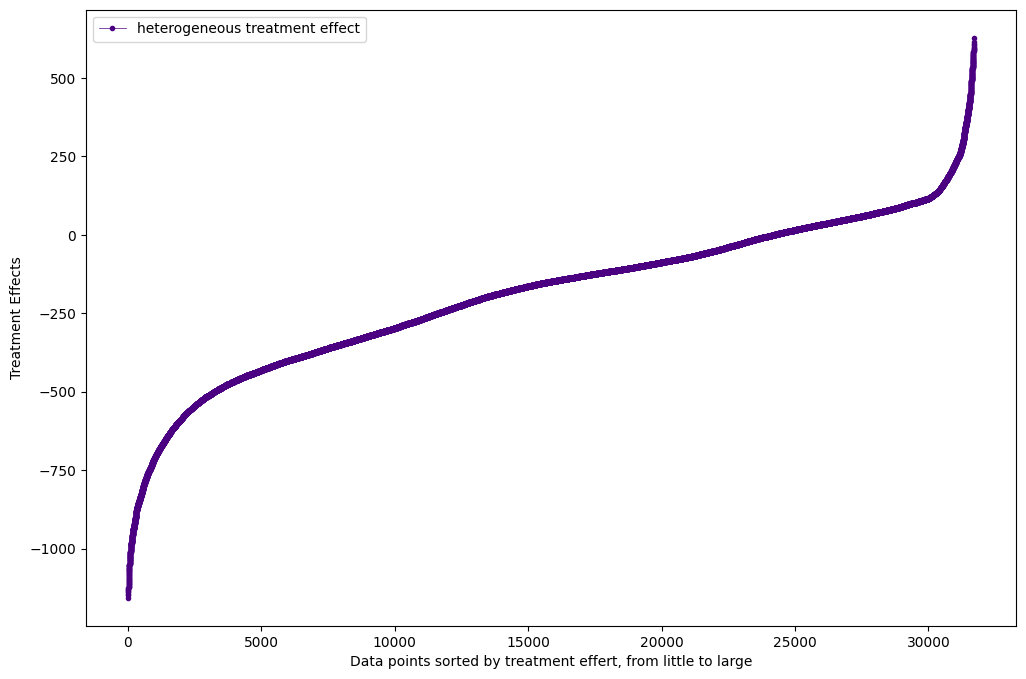

time 2023-05-30 10:12:10.555884 treatment  n_tokens_content
treatment:  n_tokens_content
average constant marginal CATE : -153.3210360636139


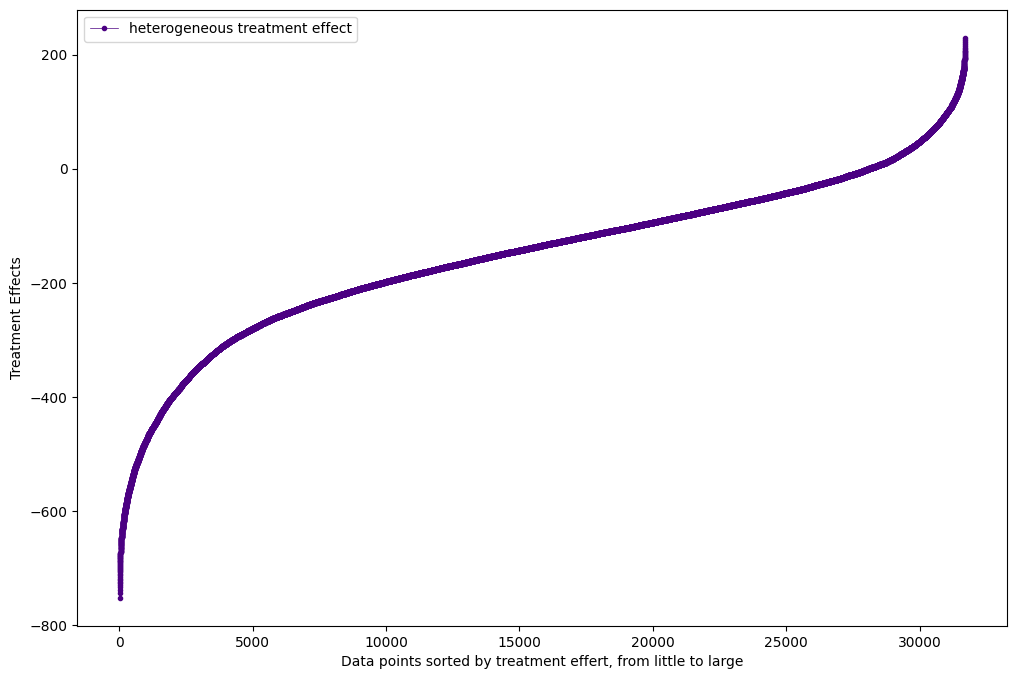

time 2023-05-30 10:30:21.815681 treatment  num_imgs
treatment:  num_imgs
average constant marginal CATE : 925.3372041786289


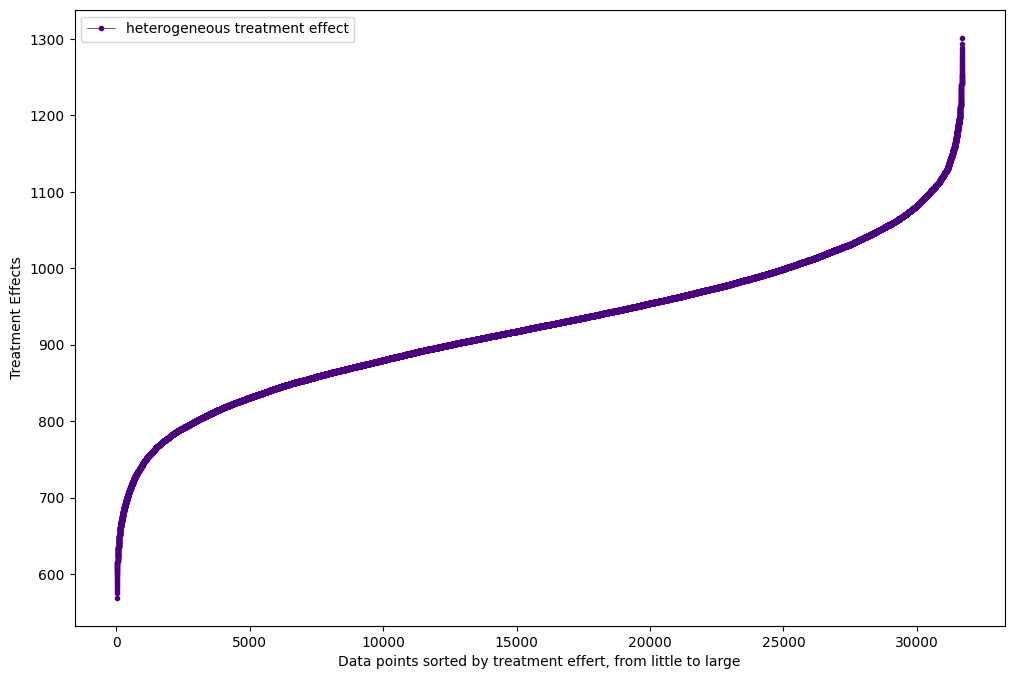

time 2023-05-30 10:48:31.441988 treatment  num_videos
treatment:  num_videos
average constant marginal CATE : 241.2537325159398


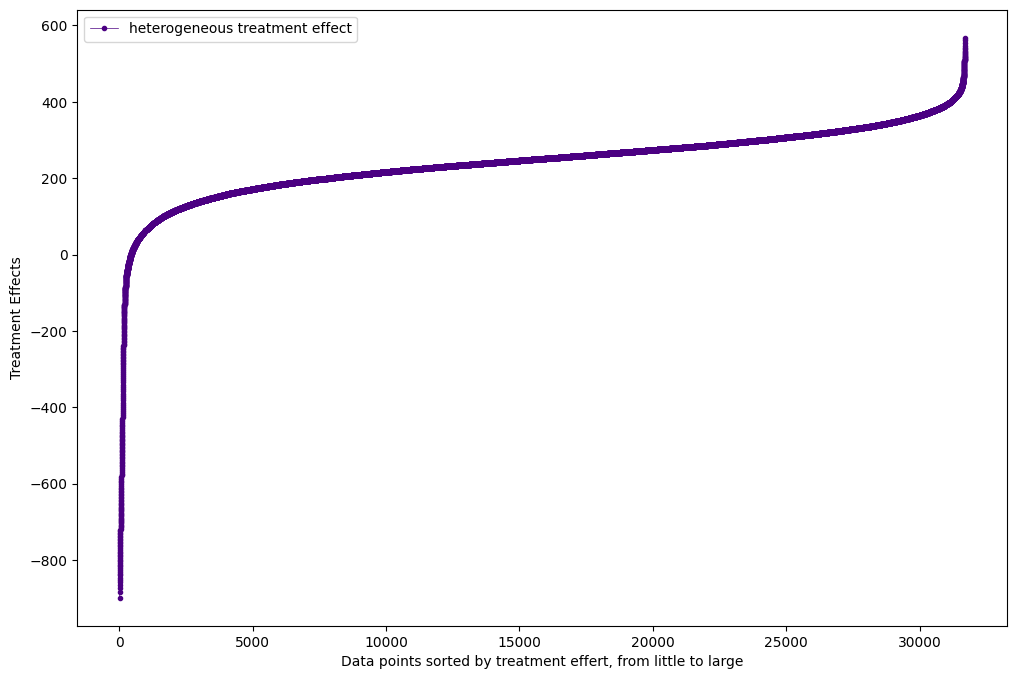

time 2023-05-30 11:06:41.867341 treatment  num_keywords
treatment:  num_keywords
average constant marginal CATE : 97.43234020957962


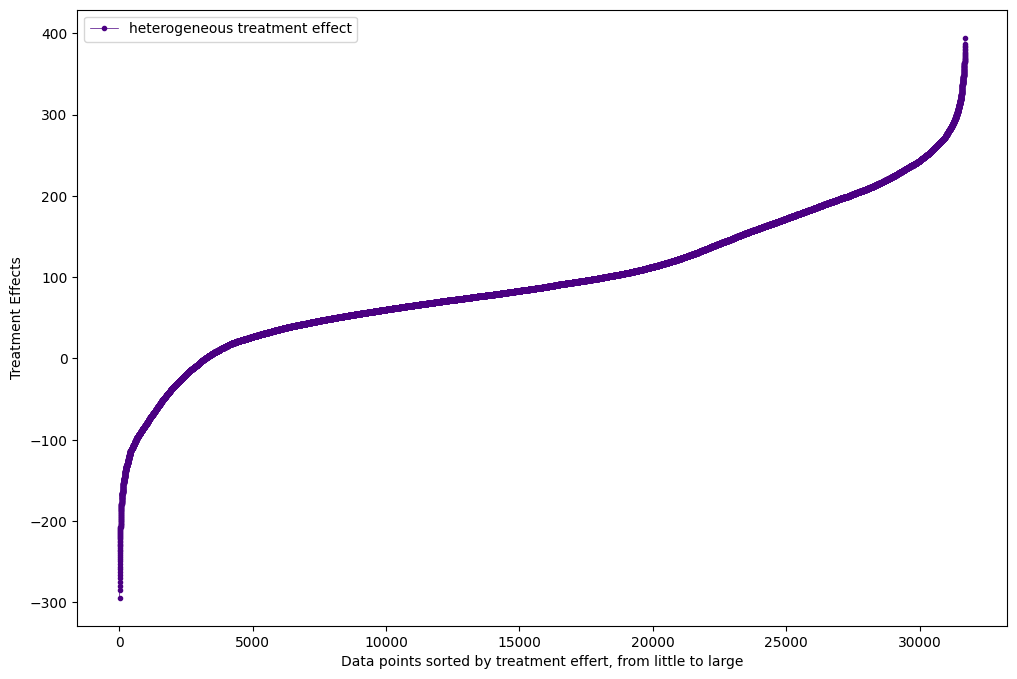

time 2023-05-30 11:25:32.616534 treatment  global_rate_positive_words
treatment:  global_rate_positive_words
average constant marginal CATE : 2260.52985209247


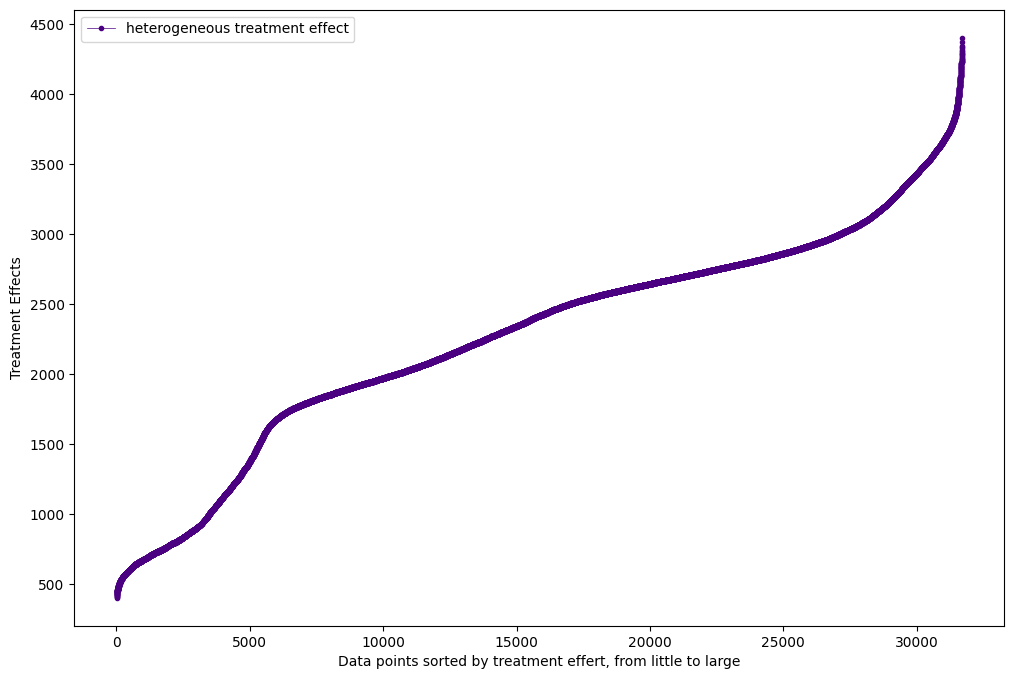

time 2023-05-30 11:43:48.269610 treatment  global_subjectivity
treatment:  global_subjectivity
average constant marginal CATE : 99.87845784440175


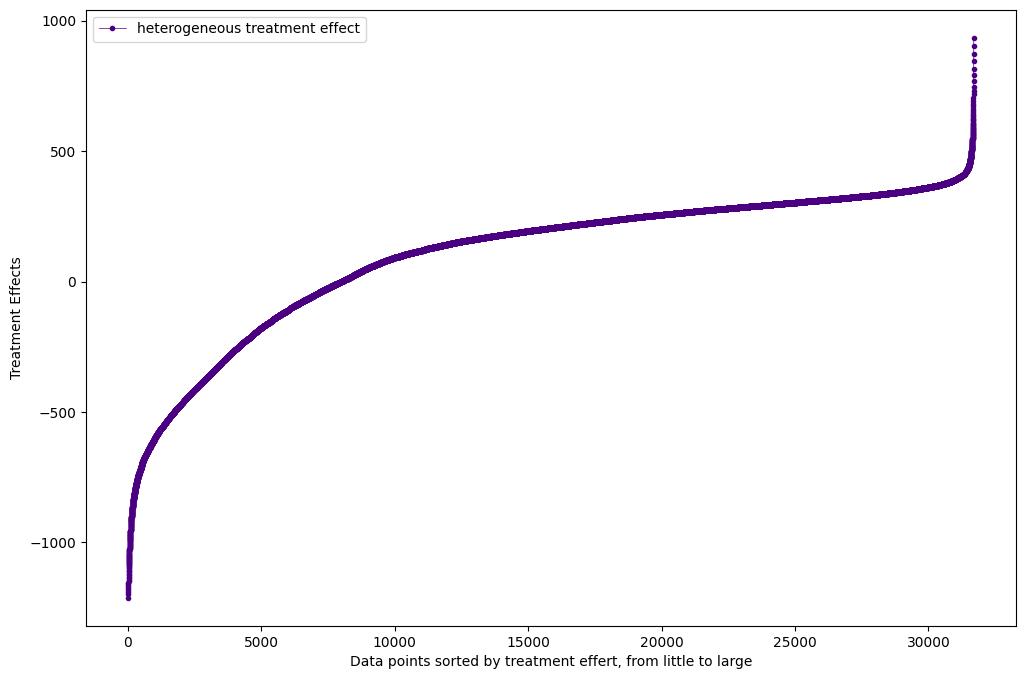

time 2023-05-30 12:01:12.831468 treatment  global_rate_negative_words
treatment:  global_rate_negative_words
average constant marginal CATE : -705.5895582947874


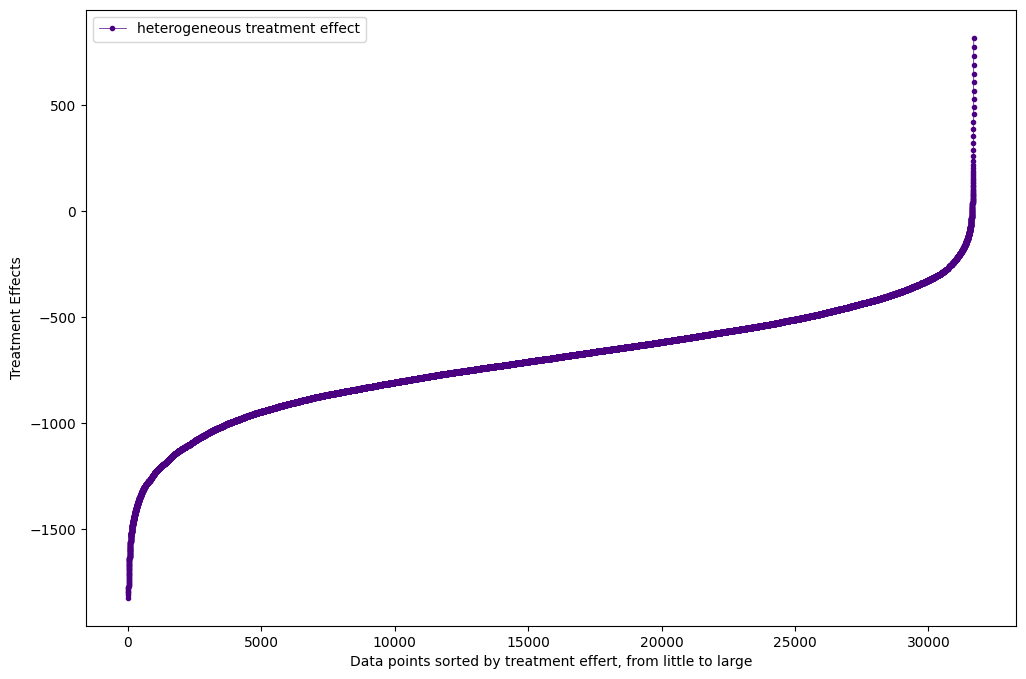

time 2023-05-30 12:18:44.043101 treatment  rate_negative_words
treatment:  rate_negative_words
average constant marginal CATE : 0.0


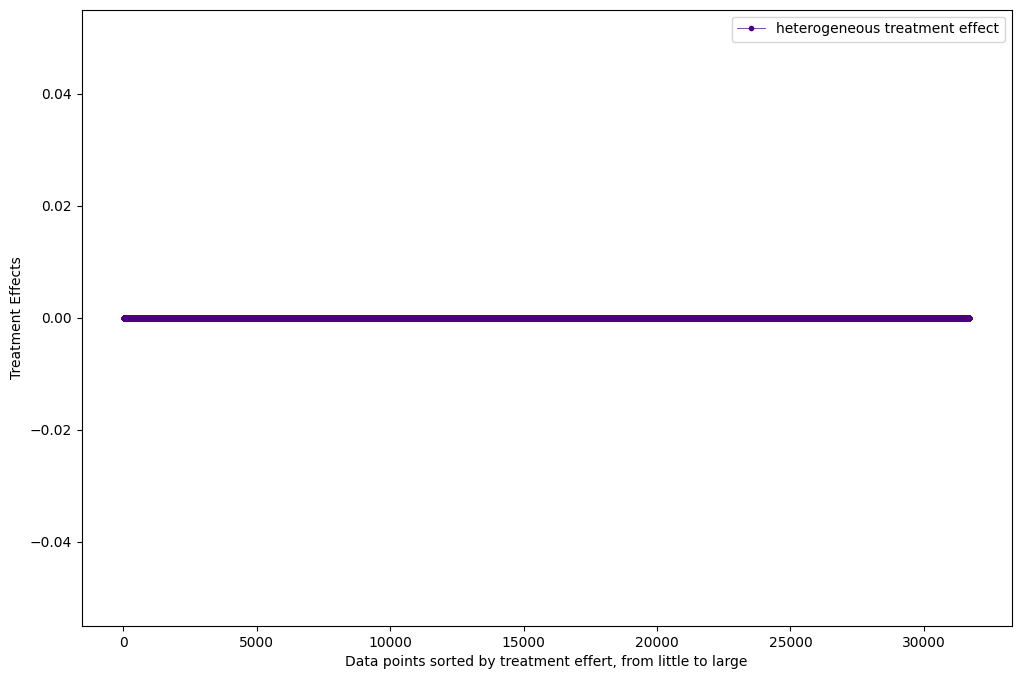

time 2023-05-30 12:35:45.011507 treatment  avg_negative_polarity
treatment:  avg_negative_polarity
average constant marginal CATE : 246.3527077321866


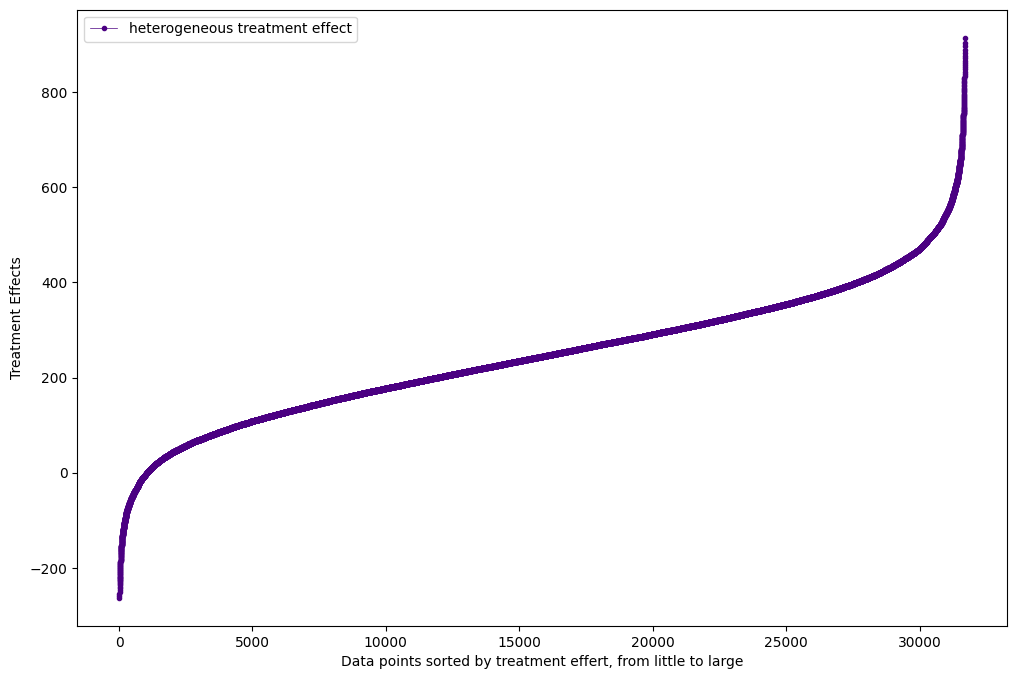

time 2023-05-30 12:53:21.864127 treatment  min_negative_polarity
treatment:  min_negative_polarity
average constant marginal CATE : -245.85462998323987


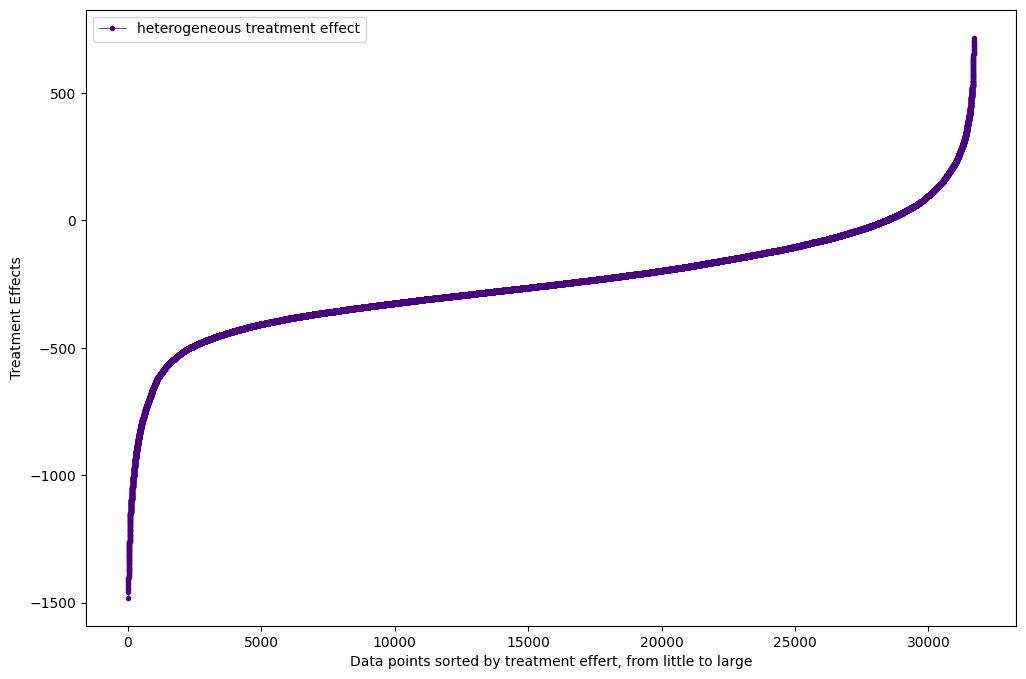

time 2023-05-30 13:12:14.525361 treatment  max_negative_polarity
treatment:  max_negative_polarity
average constant marginal CATE : -334.77783354927845


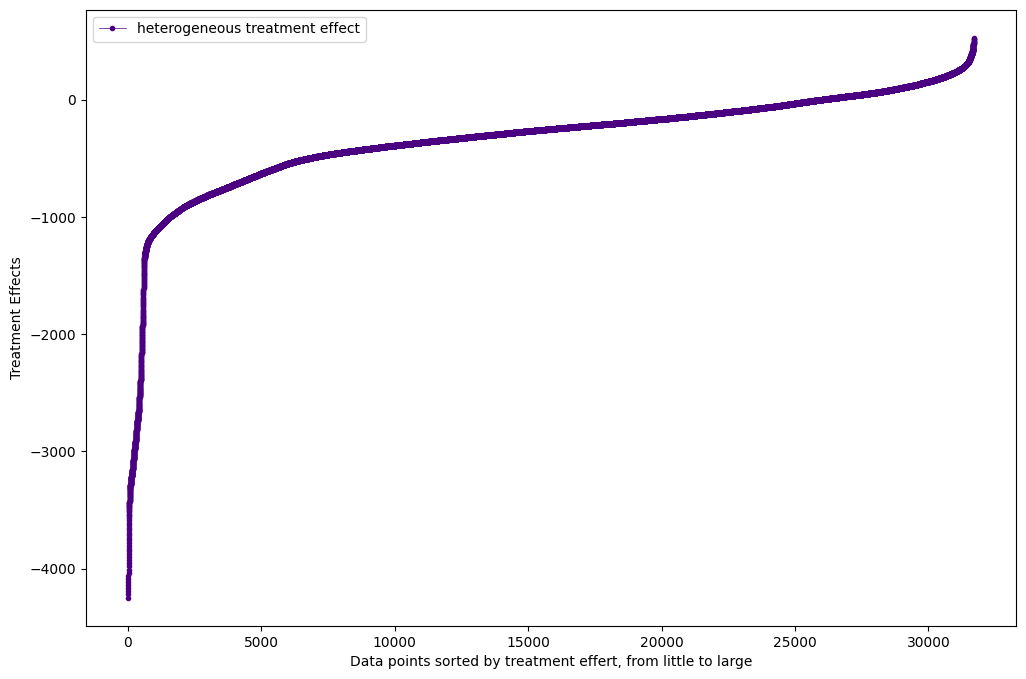

In [ ]:
for treatment in treatments:
  print( "time",datetime.now(), 'treatment',treatment)
  this_mean = df[treatment].mean()
  temp_df =  df[treatment]
  df[treatment] = np.where(df[treatment] > this_mean, 1, 0)

  run_Casual_Forest(df,treatment)
  #time.sleep(10*60)
  df[treatment] = temp_df

2023-05-27 08:02:09.964644
treatment:  n_tokens_content
CATE: -0.4169215604633412


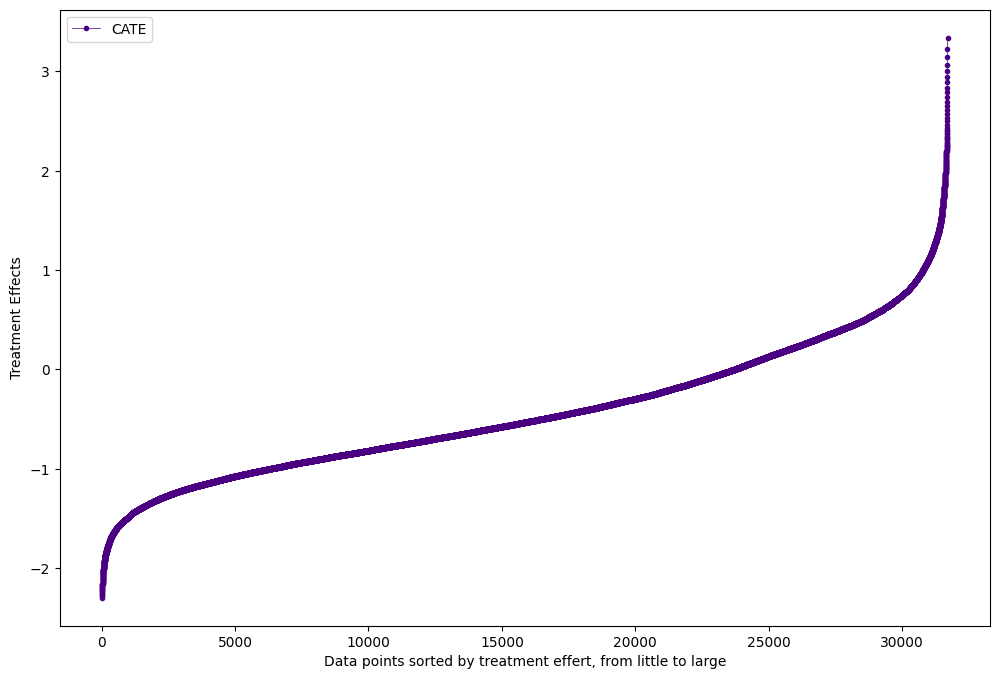

In [ ]:
print( datetime.now())
run_Casual_Forest(df,' n_tokens_content')
time.sleep(10*60)

2023-05-27 08:31:33.352020
treatment:  num_imgs
CATE: 61.2418740709548


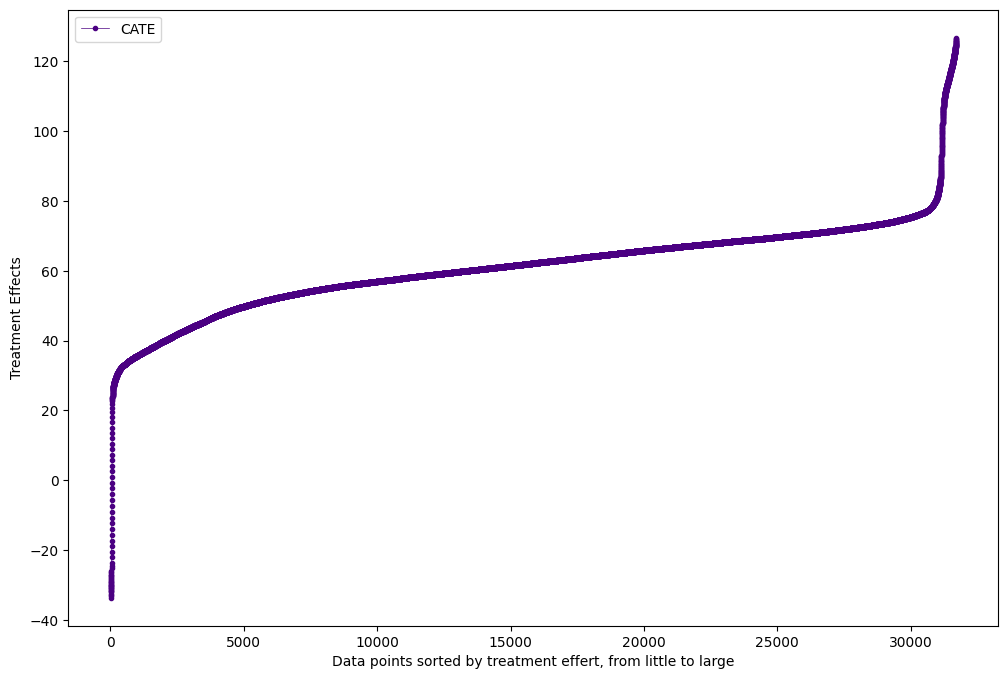

In [ ]:
print( datetime.now())
run_Casual_Forest(df,' num_imgs')
time.sleep(10*60)

2023-05-27 08:46:15.058390
treatment:  num_keywords
CATE: 1569.0447149334625


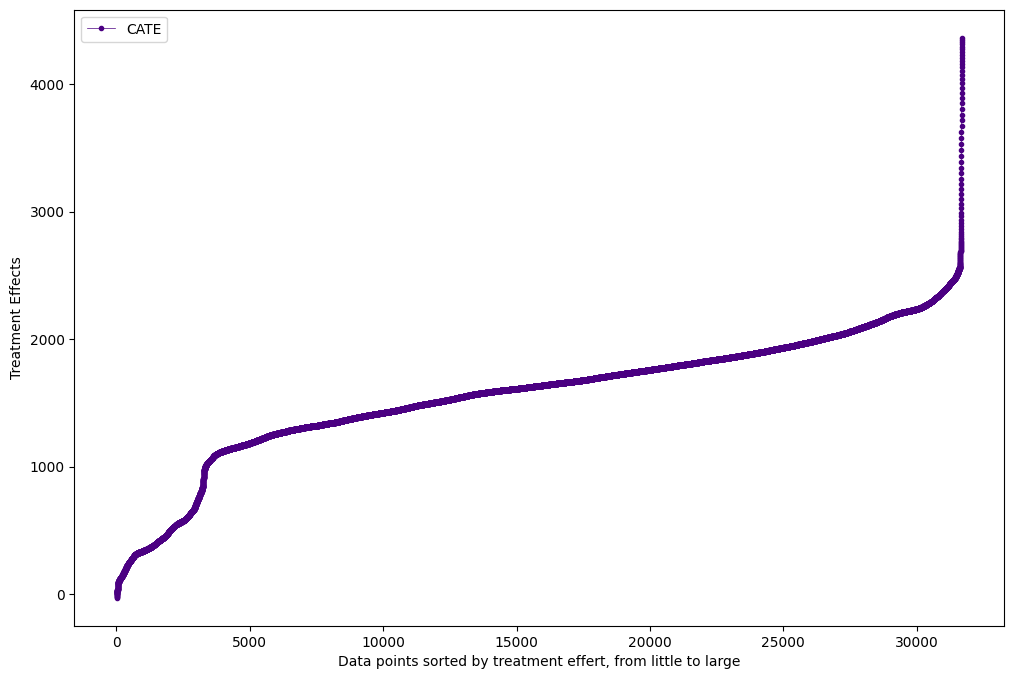

In [ ]:
print( datetime.now())
run_Casual_Forest(df,' num_keywords')
time.sleep(10*60)

2023-05-27 09:00:56.943096
treatment:  global_rate_negative_words
CATE: 135726.61205579573


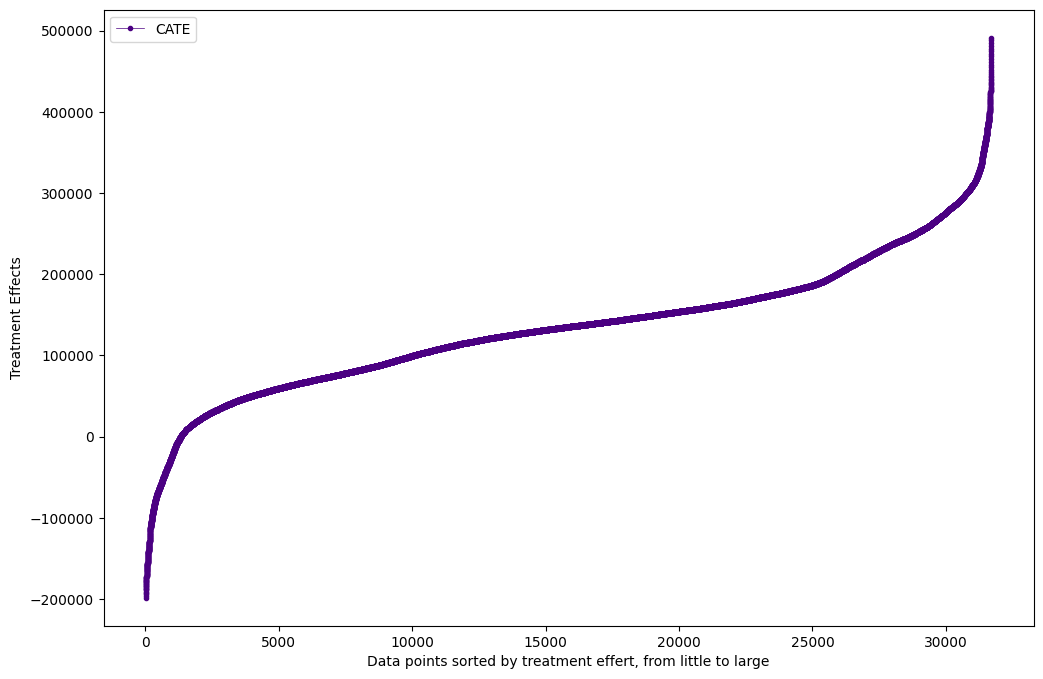

In [ ]:
print( datetime.now())
run_Casual_Forest(df,' global_rate_negative_words')
time.sleep(10*60)

2023-05-27 13:22:20.790429
treatment:  avg_negative_polarity
CATE: -2926.391547322341


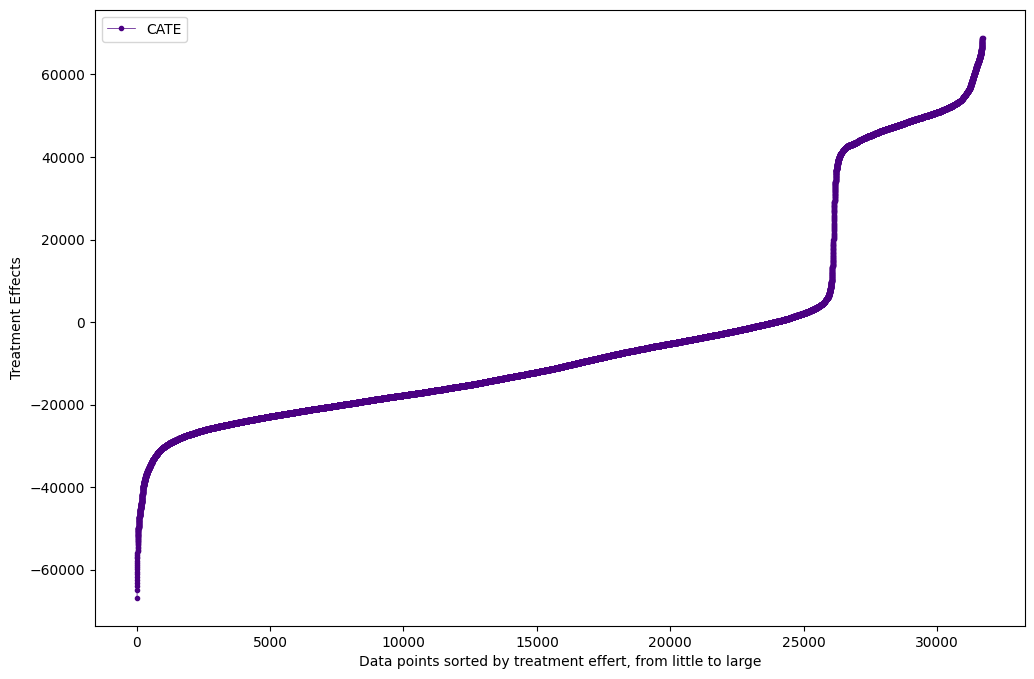

In [ ]:
print( datetime.now())
run_Casual_Forest(df,' avg_negative_polarity')
time.sleep(10*60)

2023-05-27 13:36:21.204180
treatment:  rate_negative_words
CATE: 5554806.591722244


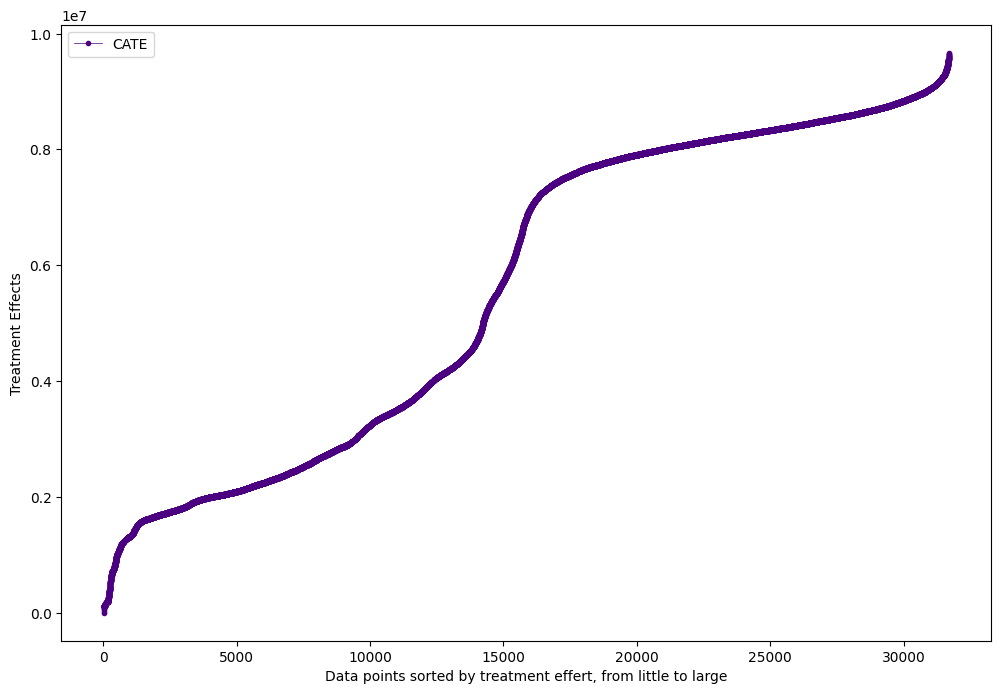

In [ ]:
print( datetime.now())
run_Casual_Forest(df,' rate_negative_words')


2023-05-27 22:19:56.662478
treatment:  max_negative_polarity
CATE: -36785.3694601082


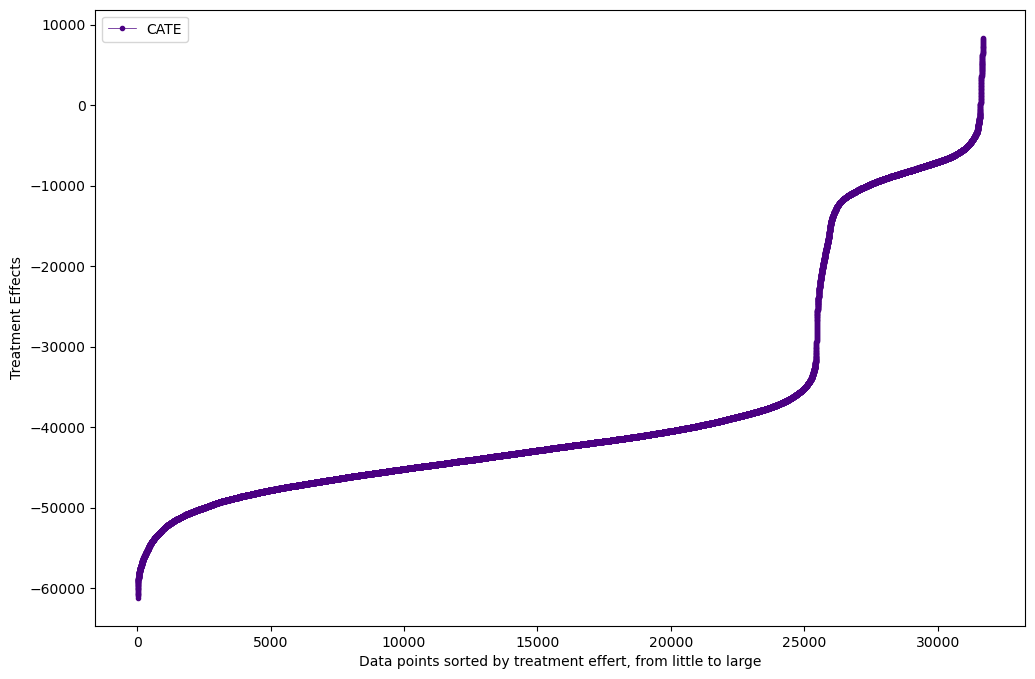

In [ ]:
print( datetime.now())
run_Casual_Forest(df,' max_negative_polarity')


2023-05-27 22:23:51.908541
treatment:  min_negative_polarity
CATE: -7937.086626258922


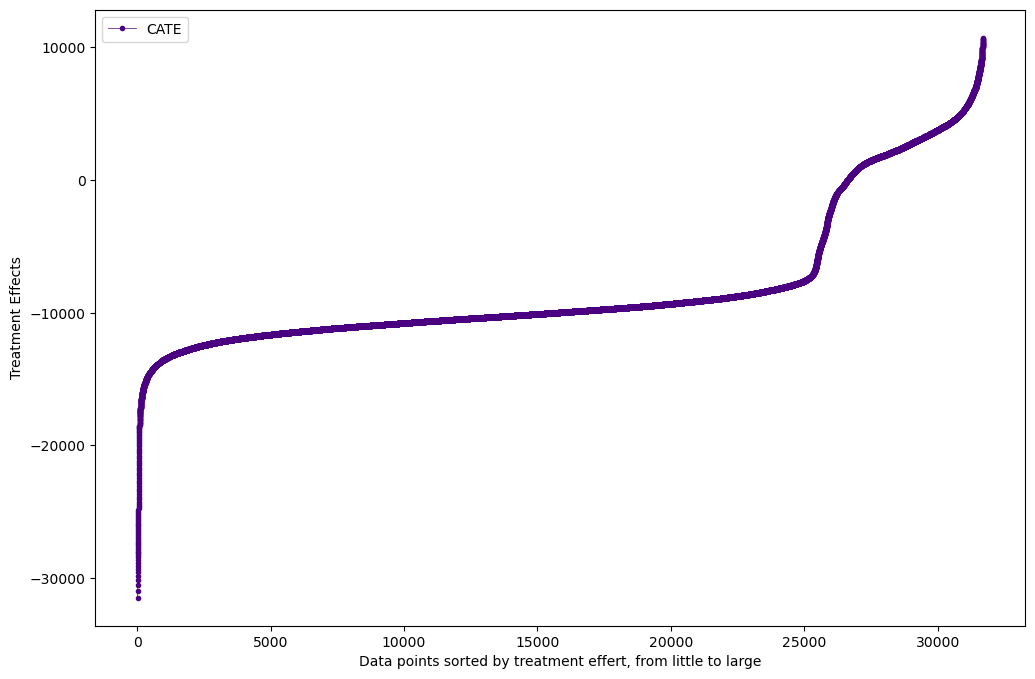

In [ ]:
print( datetime.now())
run_Casual_Forest(df,' min_negative_polarity')


In [ ]:
import pandas as pd
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from datetime import datetime
import time

In [ ]:
df = pd.read_csv('OnlineNewsPopularity_interacted.csv')

In [ ]:
df = df.drop(columns=['url'])

In [ ]:
import numpy as np

import doubleml as dml

from doubleml.datasets import make_irm_data

from sklearn.ensemble import RandomForestClassifier

np.random.seed(3141)

ml_g = RandomForestClassifier(n_estimators=50, max_features=20, max_depth=10, min_samples_leaf=2)

ml_m = RandomForestClassifier(n_estimators=50, max_features=20, max_depth=10, min_samples_leaf=2)

In [ ]:
treatments = [' n_tokens_title', ' n_tokens_content',
       ' num_imgs', ' num_videos',
       ' num_keywords', ' global_subjectivity',
       ' global_sentiment_polarity', ' global_rate_positive_words',
       ' global_rate_negative_words', ' rate_positive_words',
       ' rate_negative_words', ' avg_positive_polarity',
       ' min_positive_polarity', ' max_positive_polarity',
       ' avg_negative_polarity', ' min_negative_polarity',
       ' max_negative_polarity', ' title_subjectivity',
       ' title_sentiment_polarity', ' abs_title_subjectivity',
       ]
binary_treatments =  [' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world',
       'data_channel_is_Work',
       ' data_channel_is_Entertainment',
       ' week_end_cross_data_channel_is_Work',
       ' week_end_cross_data_channel_is_Entertainment',
       ' week_day_cross_data_channel_is_Work',
       ' week_day_cross_data_channel_is_Entertainment',
        ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend',
       ]

In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' data_channel_is_lifestyle')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' data_channel_is_lifestyle')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-27 22:27:12.600442
treatment:  data_channel_is_lifestyle


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


       coef     std err         t         P>|t|       2.5 %       97.5 %
0.25  159.0   21.929824  7.250400  4.155421e-13  116.018335   201.981665
0.50  200.0   39.091837  5.116158  3.118224e-07  123.381408   276.618592
0.75  800.0  137.195043  5.831114  5.505840e-09  531.102656  1068.897344
2023-05-27 23:26:17.698097


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' data_channel_is_entertainment')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' data_channel_is_entertainment')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-27 23:36:17.767709
treatment:  data_channel_is_entertainment


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


       coef    std err          t          P>|t|       2.5 %      97.5 %
0.25 -149.0   9.244858 -16.117067   1.935798e-58 -167.119589 -130.880411
0.50 -300.0  13.026009 -23.030845  2.288809e-117 -325.530508 -274.469492
0.75 -400.0  61.382394  -6.516527   7.195408e-11 -520.307282 -279.692718
2023-05-28 00:29:52.406542


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' data_channel_is_bus')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' data_channel_is_bus')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 00:39:52.486973
treatment:  data_channel_is_bus


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


              coef    std err             t         P>|t|       2.5 %  \
0.25 -1.500000e+01   9.807337 -1.529467e+00  1.261487e-01  -34.222027   
0.50  1.818989e-12  17.560917  1.035817e-13  1.000000e+00  -34.418766   
0.75  3.000000e+02  60.708479  4.941649e+00  7.746455e-07  181.013567   

          97.5 %  
0.25    4.222027  
0.50   34.418766  
0.75  418.986433  
2023-05-28 01:32:55.537181


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' data_channel_is_socmed')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' data_channel_is_socmed')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 01:42:55.612841
treatment:  data_channel_is_socmed


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


       coef    std err          t         P>|t|       2.5 %      97.5 %
0.25  369.0  24.606125  14.996266  7.766758e-51  320.772880  417.227120
0.50  400.0  34.976376  11.436291  2.754108e-30  331.447563  468.552437
0.75  700.0  94.057382   7.442265  9.897310e-14  515.650920  884.349080
2023-05-28 02:37:36.864132


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' data_channel_is_tech')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' data_channel_is_tech')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 02:47:36.947095
treatment:  data_channel_is_tech


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


        coef    std err          t         P>|t|       2.5 %       97.5 %
0.25   180.0  12.567159  14.323047  1.570832e-46  155.368821   204.631179
0.50   400.0  20.159475  19.841787  1.297635e-87  360.488156   439.511844
0.75  1100.0  65.417193  16.815151  1.890094e-63  971.784657  1228.215343
2023-05-28 03:39:52.776985


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' data_channel_is_world')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' data_channel_is_world')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 03:49:52.857892
treatment:  data_channel_is_world


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


        coef     std err          t         P>|t|        2.5 %       97.5 %
0.25  -153.0    8.132443 -18.813534  5.850447e-79  -168.939296  -137.060704
0.50  -100.0   15.473797  -6.462538  1.029613e-10  -130.328084   -69.671916
0.75  1400.0  140.795757   9.943481  2.692491e-23  1124.045387  1675.954613
2023-05-28 04:43:19.539135


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' data_channel_is_Work')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' data_channel_is_Work')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 04:53:19.623332
treatment:  data_channel_is_Work


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


       coef    std err          t         P>|t|       2.5 %      97.5 %
0.25   92.0   8.476741  10.853228  1.925042e-27   75.385893  108.614107
0.50  300.0  15.291686  19.618504  1.074692e-85  270.028847  329.971153
0.75  600.0  55.588321  10.793634  3.689067e-27  491.048893  708.951107
2023-05-28 05:45:50.754652


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' data_channel_is_Entertainment')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' data_channel_is_Entertainment')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 05:55:50.832398
treatment:  data_channel_is_Entertainment


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


       coef    std err          t         P>|t|       2.5 %      97.5 %
0.25 -124.0   7.895859 -15.704434  1.410299e-55 -139.475599 -108.524401
0.50 -200.0  13.583944 -14.723265  4.570520e-49 -226.624041 -173.375959
0.75 -500.0  49.646961 -10.071110  7.413665e-24 -597.306255 -402.693745
2023-05-28 06:47:15.175453


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' week_end_cross_data_channel_is_Work')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' week_end_cross_data_channel_is_Work')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 06:57:15.261341
treatment:  week_end_cross_data_channel_is_Work


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted 

        coef     std err          t         P>|t|       2.5 %       97.5 %
0.25   663.0   33.431370  19.831673  1.586737e-87  597.475718   728.524282
0.50   900.0   73.256234  12.285644  1.081803e-34  756.420419  1043.579581
0.75  1200.0  134.788855   8.902813  5.444875e-19  935.818699  1464.181301
2023-05-28 07:49:06.798356


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' week_day_cross_data_channel_is_Work')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' week_day_cross_data_channel_is_Work')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 07:59:06.896756
treatment:  week_day_cross_data_channel_is_Work


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


       coef    std err         t         P>|t|      2.5 %      97.5 %
0.25   66.0   8.283023  7.968105  1.611258e-15  49.765573   82.234427
0.50  100.0  15.372044  6.505316  7.753027e-11  69.871348  130.128652
0.75  100.0  55.690812  1.795628  7.255365e-02  -9.151987  209.151987
2023-05-28 08:51:16.208360


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' week_end_cross_data_channel_is_Entertainment')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' week_end_cross_data_channel_is_Entertainment')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 09:01:16.274259
treatment:  week_end_cross_data_channel_is_Entertainment


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


       coef    std err          t         P>|t|       2.5 %      97.5 %
0.25  270.0  16.436012  16.427342  1.218846e-60  237.786008  302.213992
0.50  400.0  29.188369  13.704089  9.596463e-43  342.791848  457.208152
0.75  700.0  98.963356   7.073325  1.512645e-12  506.035386  893.964614
2023-05-28 09:52:25.594940


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' week_day_cross_data_channel_is_Entertainment')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' week_day_cross_data_channel_is_Entertainment')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 10:02:25.676621
treatment:  week_day_cross_data_channel_is_Entertainment


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


       coef    std err          t          P>|t|       2.5 %      97.5 %
0.25 -255.0   8.307390 -30.695562  6.523277e-207 -271.282185 -238.717815
0.50 -300.0  12.499810 -24.000365  2.756460e-127 -324.499177 -275.500823
0.75 -500.0  45.290534 -11.039835   2.454847e-28 -588.767815 -411.232185
2023-05-28 10:55:09.372086


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' weekday_is_monday')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' weekday_is_monday')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 11:05:09.440134
treatment:  weekday_is_monday


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


              coef    std err             t     P>|t|       2.5 %      97.5 %
0.25 -3.300000e+01  10.292937 -3.206082e+00  0.001346  -53.173786  -12.826214
0.50 -1.591616e-12  16.246209 -9.796844e-14  1.000000  -31.841985   31.841985
0.75  1.818989e-12  58.155070  3.127826e-14  1.000000 -113.981842  113.981842
2023-05-28 11:58:58.556915


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' weekday_is_tuesday')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' weekday_is_tuesday')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 12:08:58.638738
treatment:  weekday_is_tuesday


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


       coef    std err         t         P>|t|       2.5 %      97.5 %
0.25  -59.0   9.925113 -5.944517  2.772734e-09  -78.452864  -39.547136
0.50 -100.0  13.809150 -7.241576  4.435021e-13 -127.065436  -72.934564
0.75 -300.0  50.129925 -5.984449  2.171230e-09 -398.252847 -201.747153
2023-05-28 13:03:10.608811


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' weekday_is_wednesday')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' weekday_is_wednesday')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 13:13:10.663767
treatment:  weekday_is_wednesday


Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.
Subsample has not common support. Results are based on adjusted propensities.


KeyboardInterrupt: 

In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' weekday_is_thursday')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' weekday_is_thursday')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' weekday_is_friday')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' weekday_is_friday')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' weekday_is_saturday')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' weekday_is_saturday')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

2023-05-28 14:38:14.982215
treatment:  weekday_is_saturday


C:\Users\user\anaconda3\envs\finance\lib\site-packages\doubleml\_utils.py:283: UserWarning: Subsample has not common support. Results are based on adjusted propensities.
  warnings.warn("Subsample has not common support. Results are based on adjusted propensities.")
C:\Users\user\anaconda3\envs\finance\lib\site-packages\doubleml\_utils.py:283: UserWarning: Subsample has not common support. Results are based on adjusted propensities.
  warnings.warn("Subsample has not common support. Results are based on adjusted propensities.")
C:\Users\user\anaconda3\envs\finance\lib\site-packages\doubleml\_utils.py:283: UserWarning: Subsample has not common support. Results are based on adjusted propensities.
  warnings.warn("Subsample has not common support. Results are based on adjusted propensities.")
C:\Users\user\anaconda3\envs\finance\lib\site-packages\doubleml\_utils.py:283: UserWarning: Subsample has not common support. Results are based on adjusted propensities.
  warnings.warn("Subsample ha

       coef    std err          t         P>|t|       2.5 %      97.5 %
0.25  367.0  23.874357  15.372142  2.517077e-53  320.207121  413.792879
0.50  600.0  35.277170  17.008167  7.143814e-65  530.858017  669.141983
0.75  800.0  85.125243   9.397917  5.565368e-21  633.157590  966.842410
2023-05-28 15:28:44.198414


In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' weekday_is_sunday')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' weekday_is_sunday')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)
time.sleep(60*10)

In [ ]:
print(datetime.now())
obj_dml_data = dml.DoubleMLData(df, ' shares', ' is_weekend')
dml_qte_obj = dml.DoubleMLQTE(obj_dml_data, ml_g, ml_m, score='PQ', quantiles=[0.25, 0.5, 0.75])
print("treatment:",' is_weekend')
print(dml_qte_obj.fit().summary)
current_dateTime = datetime.now()
print(current_dateTime)


2023-05-28 15:38:44.285872
treatment:  is_weekend


C:\Users\user\anaconda3\envs\finance\lib\site-packages\doubleml\_utils.py:283: UserWarning: Subsample has not common support. Results are based on adjusted propensities.
  warnings.warn("Subsample has not common support. Results are based on adjusted propensities.")
C:\Users\user\anaconda3\envs\finance\lib\site-packages\doubleml\_utils.py:283: UserWarning: Subsample has not common support. Results are based on adjusted propensities.
  warnings.warn("Subsample has not common support. Results are based on adjusted propensities.")
C:\Users\user\anaconda3\envs\finance\lib\site-packages\doubleml\_utils.py:283: UserWarning: Subsample has not common support. Results are based on adjusted propensities.
  warnings.warn("Subsample has not common support. Results are based on adjusted propensities.")
C:\Users\user\anaconda3\envs\finance\lib\site-packages\doubleml\_utils.py:283: UserWarning: Subsample has not common support. Results are based on adjusted propensities.
  warnings.warn("Subsample ha

       coef    std err          t          P>|t|       2.5 %       97.5 %
0.25  384.0  14.714181  26.097273  3.915149e-150  355.160735   412.839265
0.50  500.0  23.751877  21.050968   2.240579e-98  453.447176   546.552824
0.75  900.0  64.912810  13.864752   1.035837e-43  772.773230  1027.226770
2023-05-28 16:29:20.871760
